# Fractional Cover

## This notebook is currently under development!

## Notebook Summary

This notebook provides a fractional cover product which can be used to represent land cover. 

The basis for this notebook below and the following explanation are from Digital Earth Australia http://geoscienceaustralia.github.io/digitalearthau/notebooks/02_DEA_datasets/Introduction_to_Fractional_Cover.html.

### What is Fractional Cover

Fractional Cover represents the proportion of the land surface that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynethic vegetation (NPV).

The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program (JRSRP) which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions. The fractions were retrieved by inverting multiple linear regression estimates and using synthetic endmembers in a constrained non-negative least squares unmixing model.

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.

### Fractional Cover Bands

Bare Soil (bare ground, rock, disturbed) (BS): - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

Photosythetic Vegetation. (green grass, trees, etc.) (PV): - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

Non-Photosythetic vegetation (litter, dead leaf and branches) (NPV): - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

Unmixing Error (UE): - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components.

This notebook builds on teh single L8 image with cloud and water mask provided by Digital Earth Austrlia to provide a median product for a time range. This reduces the influence of cloud and variability associated with water identification. 

The product has also been developed to function for Landsat-7, Landsat-5, Landsat-4 and Sentinel-2. 

Additionally a change product will be produced to allow for areas where changes in land cover have been experienced to be identified. 


### Install requirements

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [3]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr

import numpy as np
import xarray as xr
import dask

## Initialise

In [4]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [5]:
#set baseline start and end of period
baseline_start_date = '2019-1-1'
baseline_end_date = '2019-3-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
platform = "SENTINEL_2"

aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:32760"

## Translate inputs

In [6]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)


In [7]:
#create resolution
resolution = (-res, res)

In [8]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [9]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [10]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [11]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]

def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [12]:
product, measurement, water_product = create_product_measurement(platform)

## Load Data 

In [13]:
query = {
    'longitude': lon_extents,
    'latitude': lat_extents,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
    'dask_chunks': dask_chunks
}

In [14]:
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)

In [15]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


In [16]:
#create per scene cloud mask
#cloud_mask = landsat_qa_clean_mask(ds, platform)
#clearsky_scenes = ds.where(cloud_mask)

## Load Water Masks

In [17]:
#water_classes.isel(time = 4).water_classification.plot();

## Mask cloud

In [18]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification != 0) & # mask out NO_DATA
            (ds.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (ds.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (ds.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (ds.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (ds.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (ds.scene_classification != 10)&  # mask out THIN_CIRRUS
            (ds.scene_classification != 11)  # mask out SNOW
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [19]:
good_quality = look_up_clean(platform, ds)

In [20]:
clearsky_scenes = ds.where(good_quality)

In [21]:
#when S2 mask is ready - can remove the if statement. 
if platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes = dc.load(product=water_product,
              measurements = ["water_classification"],
               **query)
    #change clouds to no data value
    water_classes = water_scenes.where(water_scenes >= 0)
elif platform in ["SENTINEL_2"]:
    water_classes = dask.delayed(wofs_classify)(ds, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes = dask.delayed(water_classes.rename({'wofs': 'water_classification'}))
          

## Create mosaic of water mask

# GOT TO HERE

In [22]:
#create mosaic of water mask
water_composite_mean = water_classes.water_classification.mean(dim='time')

In [23]:
#water_composite_mean = water_composite.compute()

In [24]:
#create mosaic
land_composite = dask.delayed(create_median_mosaic)(clearsky_scenes, clean_mask = good_quality, no_data = np.nan)

In [25]:
land_composite = land_composite.rename({"x":"longitude", "y":"latitude"})
frac_classes = dask.delayed(frac_coverage_classify)(land_composite, no_data = np.nan)

## Plot Fractional Cover

In [26]:
#frac_classes = booleanMask
#no_data_mask = np.logical_or(np.isnan(land_composite.red.values), np.isnan(land_composite.red.values)) 
#frac_cov_new = frac_classes.where(no_data_mask == False)

#plot the fractional cover bands.
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
frac_cov_new.pv.plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
frac_cov_new.bs.plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
frac_cov_new.npv.plot(cmap='copper')
ax3.set_title('NPV')

plt.tight_layout()
plt.show()

## Mask Fractional Cover By Water and Cloud

In [27]:
# mask to removeclouds, cloud shadow, and water. 
frac_cov_masked = frac_classes.where(water_composite_mean.values <= 0.4).where(frac_classes != np.nan)

In [28]:
%%time
frac_cov_masked = frac_cov_masked.compute()

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube_utilities/dc_water_classifier.py:119: RuntimeWarning: invalid value encountered in true_divide
  return (a - b) / (a + b)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube_utilities/dc_water_classifier.py:139: RuntimeWarning: invalid value encountered in less_equal
  r1 = ndi_52 <= -0.01
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube_utilities/dc_water_classifier.py:149: RuntimeWarning: invalid value encountered in less_equal
  r4 = ndi_43 <= 0.61
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube_utilities/dc_water_classifier.py:156: RuntimeWarning: invalid value encountered in less_equal
  r6 = ndi_43 <= -0.01
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube_utilities/dc_water_classifier.py:162: RuntimeWarning: invalid value encountered in less_equal
  r7 = ndi_72 <= -0.23
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube_utilities/dc_water_classifier.py:171: Runtime

CPU times: user 41.7 s, sys: 14 s, total: 55.8 s
Wall time: 48 s


## Create a plot showing FC components.

#Current mask issues in south west corner - with the water mask. 

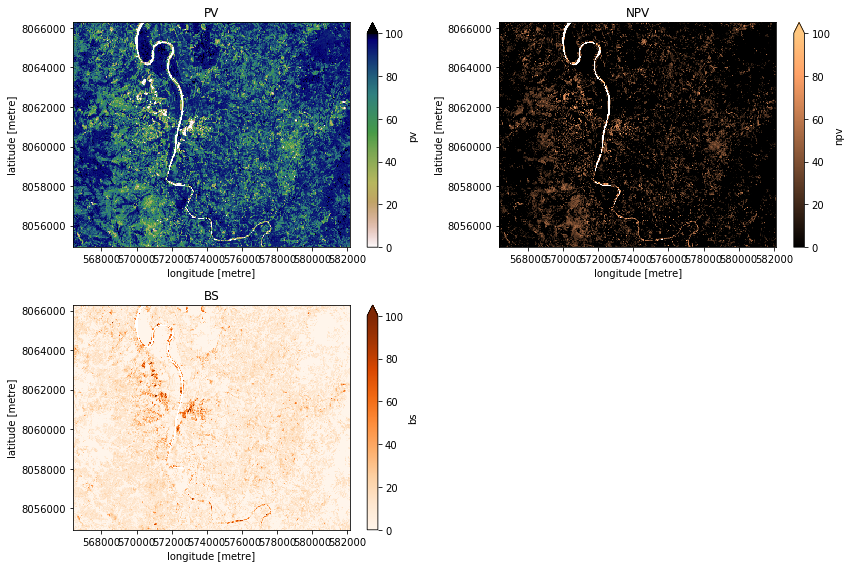

In [29]:
#plot the fractional cover bands. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
frac_cov_masked.pv.plot(cmap='gist_earth_r', vmin = 0, vmax = 100)
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
frac_cov_masked.bs.plot(cmap='Oranges', vmin = 0, vmax = 100)
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
frac_cov_masked.npv.plot(cmap='copper', vmin = 0, vmax = 100)
ax3.set_title('NPV')

plt.tight_layout()
plt.show()

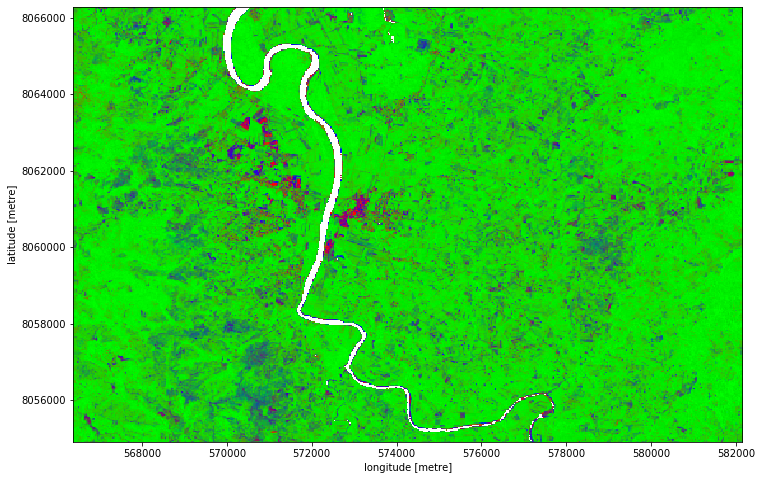

In [30]:
# Plot fractional cover as cloud free RGB image 
frac_cov_masked[['bs','pv','npv']].to_array().plot.imshow(
    #col='time',
    figsize=(12, 8),
    vmin=0,
    vmax=100
);

In [ ]:
write_geotiff_from_xr('fractional_cover.tiff', frac_cov_masked, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

---